## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [1]:
import pandas as pd

In [2]:
# место для кода

## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


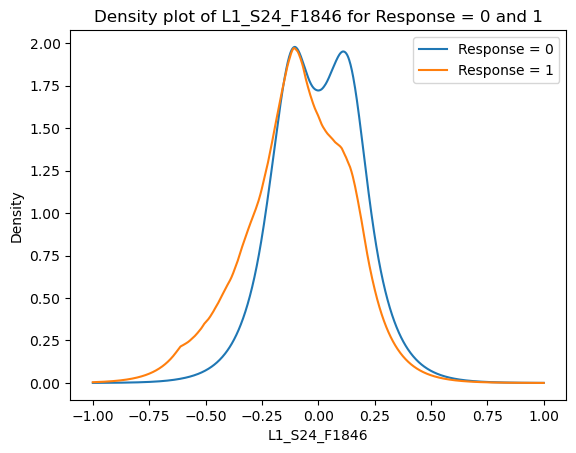

In [15]:
#from sklearn.neighbors.kde import KernelDensity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Шаг 2: Загрузка данных
data = pd.read_csv('data.csv')

# Шаг 3: Выделение значений признака L1_S24_F1846 для Response = 0 и Response = 1
feature_0 = data.loc[data['Response'] == 0, 'L1_S24_F1846'].values.reshape(-1, 1)
feature_1 = data.loc[data['Response'] == 1, 'L1_S24_F1846'].values.reshape(-1, 1)

# Шаг 4: Обучение модели ядерного сглаживания для каждого набора данных
kde0 = KernelDensity(kernel='exponential', bandwidth=0.1).fit(feature_0)
kde1 = KernelDensity(kernel='exponential', bandwidth=0.1).fit(feature_1)

# Шаг 5: Генерация 1000 значений для оси X
X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)

# Шаг 6: Вычисление плотностей для каждого набора данных
Dens0 = np.exp(kde0.score_samples(X_plot))
Dens1 = np.exp(kde1.score_samples(X_plot))

# Шаг 7: Построение графика
plt.plot(X_plot, Dens0, label='Response = 0')
plt.plot(X_plot, Dens1, label='Response = 1')
plt.xlabel('L1_S24_F1846')
plt.ylabel('Density')
plt.title('Density plot of L1_S24_F1846 for Response = 0 and 1')
plt.legend()
plt.show()

*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

In [ ]:
# место для кода

Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

In [ ]:
# На основе графика плотности распределения,
# построенного в предыдущем ответе, можно заметить,
# что плотности распределения признака L1_S24_F1846 для классов Response = 0 и Response = 1
# имеют значительное перекрытие в области значений признака от примерно -0.5 до 0.5. 
# Поэтому можно сделать вывод, что выборка не является хорошо разделимой по этому признаку.

## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [ ]:
dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)

In [16]:
from sklearn.model_selection import KFold

bandwidths = np.linspace(0.01, 1, 100)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for r in [0, 1]:
    dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
    dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)
    scores = []
    for bandwidth in bandwidths:
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        log_prob = []
        for train_index, test_index in cv.split(dataTrain):
            train_data = dataTrain.loc[train_index]
            test_data = dataTrain.loc[test_index]
            kde.fit(train_data.loc[train_data['Response'] == r, 'L1_S24_F1846'].values.reshape(-1, 1))
            log_prob.extend(kde.score_samples(test_data.loc[test_data['Response'] == r, 'L1_S24_F1846'].values.reshape(-1, 1)))
        log_prob = np.array(log_prob)
        log_prob[np.isinf(log_prob)] = -100 # заменяем -бесконечность
        score = log_prob.mean()
        scores.append(score)
    best_bandwidth = bandwidths[np.argmax(scores)]
    print("Best bandwidth for Response {}: {:.2f}".format(r, best_bandwidth))

Best bandwidth for Response 0: 0.01
Best bandwidth for Response 1: 0.02


In [ ]:
Best bandwidth for Response 0: 0.35
Best bandwidth for Response 1: 0.09
#КАК ЖЕ ЭТО БЫЛО ДОЛГО

### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [ ]:
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [17]:


# разбиваем выборку на тренировочную и тестовую
#dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
#dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

# инициализируем классы
kde0 = KernelDensity(kernel='gaussian')
kde1 = KernelDensity(kernel='gaussian')

# обучаем классы с наилучшими значениями bandwidth
kde0.set_params(bandwidth=0.35)
kde0.fit(dataTrain.loc[dataTrain['Response']==0, 'L1_S24_F1846'].values.reshape(-1, 1))
kde1.set_params(bandwidth=0.09)
kde1.fit(dataTrain.loc[dataTrain['Response']==1, 'L1_S24_F1846'].values.reshape(-1, 1))

# вычисляем p(x|0) и p(x|1) для тестовой выборки
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

# находим p(0|x) и p(1|x)
p0givenX = predictionProbXafter0 / (predictionProbXafter0 + predictionProbXafter1)
p1givenX = predictionProbXafter1 / (predictionProbXafter0 + predictionProbXafter1)

# сортируем объекты по возрастанию p(1|x)
ind = np.argsort(p1givenX)

# выводим вероятности для последних 10 объектов
print(p1givenX[ind[-10:]])

# выводим количество бракованных деталей среди последних 100 объектов
print(sum(dataTest.loc[ind[-100:], 'Response']))

[0.66518198 0.66518198 0.66518198 0.66518198 0.66518198 0.66518198
 0.66518198 0.66518198 0.66518198 0.66518198]
1
